https://www.youtube.com/watch?v=Gdpaita5GcE&t=380s

## Import Libaries

In [1]:
import yfinance as yf
import datetime as dt
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
plt.style.use("seaborn")


## Get BTC Data

In [2]:
#import btc returns data
import datetime
import yfinance as yf
import numpy as np

def get_market_data(ticker, start_date, end_date, interval):
    data = yf.download(ticker, start=start_date, end=end_date, interval=interval, group_by='ticker', ignore_tz = False)
    data["returns"] = np.log(data.Close / data.Close.shift(1))
    data["creturns"] = data["returns"].cumsum().apply(np.exp)
    return data[["returns", "creturns"]]

end_date = dt.datetime.now()
# end_date = '2020-01-01'
start_date = '2017-01-01'
interval = '1D'

df = get_market_data("BTC-USD", start_date, end_date, interval)
df.index = df.index.tz_localize('UTC')
df

[*********************100%***********************]  1 of 1 completed


,returns,creturns
Date,,
2017-01-01 00:00:00+00:00,NaN,NaN
2017-01-02 00:00:00+00:00,0.023193,1.023464
2017-01-03 00:00:00+00:00,0.021389,1.045591
2017-01-04 00:00:00+00:00,0.100960,1.156667
2017-01-05 00:00:00+00:00,-0.130575,1.015080
...,...,...
2023-04-17 00:00:00+00:00,-0.029129,29.494448
2023-04-18 00:00:00+00:00,0.031836,30.448554
2023-04-19 00:00:00+00:00,-0.053200,28.871038


## Find Pivot Points

In [3]:
def find_pivs(dataframe, window, days_high):  
    data = dataframe.copy()
    if window >= days_high:
        counter_lst = []
        data['creturns_max'] = data['creturns'].rolling(window+1, min_periods=1).max()
        data['prev_max'] = data['creturns_max'].shift(1)

        counter = 0

        for i, row in data.iterrows():
            current_max = row['creturns_max']
            previous_max = row['prev_max']
            if current_max == previous_max:
                counter +=1
            else:
                counter =0
            counter_lst.append(counter)
            if counter == days_high:
                counter = 0

        data['counter'] = counter_lst
        data['pivot_points_established'] = np.where(data.counter == days_high, data.creturns_max, np.nan)

        return data
    
window = 10
days_high = 10
    
df_pivots = find_pivs(df, window=window, days_high=days_high)
df_pivots

,returns,creturns,creturns_max,prev_max,counter,pivot_points_established
Date,,,,,,
2017-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,0,NaN
2017-01-02 00:00:00+00:00,0.023193,1.023464,1.023464,NaN,0,NaN
2017-01-03 00:00:00+00:00,0.021389,1.045591,1.045591,1.023464,0,NaN
2017-01-04 00:00:00+00:00,0.100960,1.156667,1.156667,1.045591,0,NaN
2017-01-05 00:00:00+00:00,-0.130575,1.015080,1.156667,1.156667,1,NaN
...,...,...,...,...,...,...
2023-04-17 00:00:00+00:00,-0.029129,29.494448,30.536848,30.536848,3,NaN
2023-04-18 00:00:00+00:00,0.031836,30.448554,30.536848,30.536848,4,NaN
2023-04-19 00:00:00+00:00,-0.053200,28.871038,30.536848,30.536848,5,NaN


## Find place the pivot point started for plot

In [4]:
pivot_list = df_pivots['pivot_points_established'].dropna().unique()
index_lst = [(pivot, i) for pivot in pivot_list for i in df.index[df.creturns == pivot]]
df_pivots = df_pivots.join(pd.DataFrame(index_lst, columns=['pivot_first_hit', 'index_value']).set_index('index_value').pivot_first_hit)
df_pivots

,returns,creturns,creturns_max,prev_max,counter,pivot_points_established,pivot_first_hit
Date,,,,,,,
2017-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,0,NaN,NaN
2017-01-02 00:00:00+00:00,0.023193,1.023464,1.023464,NaN,0,NaN,NaN
2017-01-03 00:00:00+00:00,0.021389,1.045591,1.045591,1.023464,0,NaN,NaN
2017-01-04 00:00:00+00:00,0.100960,1.156667,1.156667,1.045591,0,NaN,1.156667
2017-01-05 00:00:00+00:00,-0.130575,1.015080,1.156667,1.156667,1,NaN,NaN
...,...,...,...,...,...,...,...
2023-04-17 00:00:00+00:00,-0.029129,29.494448,30.536848,30.536848,3,NaN,NaN
2023-04-18 00:00:00+00:00,0.031836,30.448554,30.536848,30.536848,4,NaN,NaN
2023-04-19 00:00:00+00:00,-0.053200,28.871038,30.536848,30.536848,5,NaN,NaN


## Plot pivots

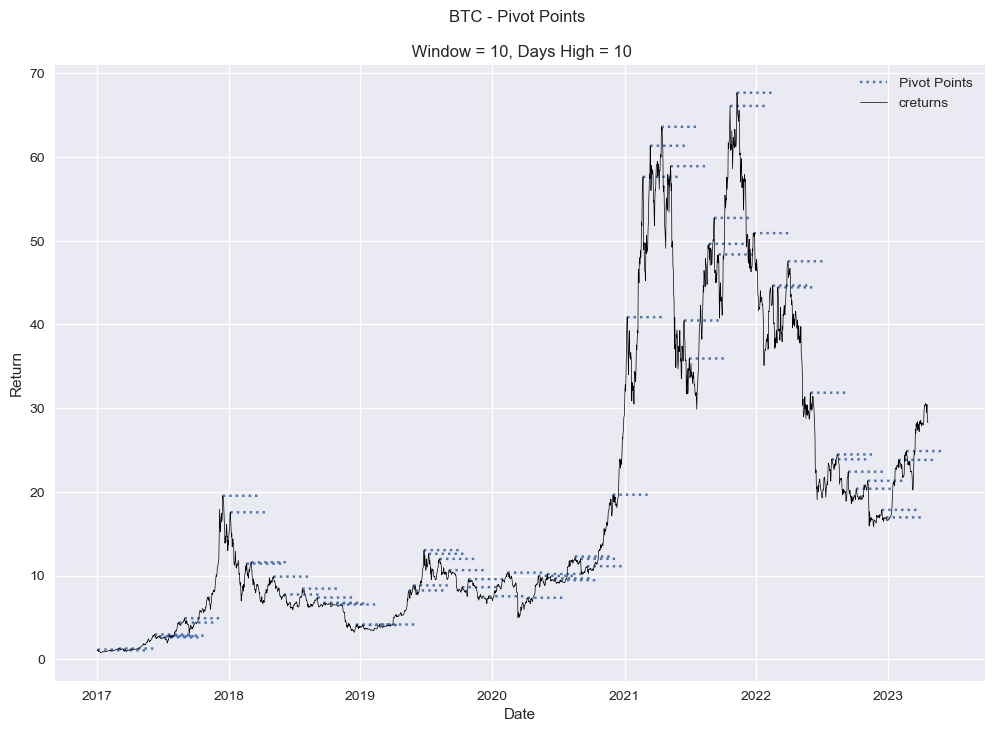

In [5]:
from datetime import datetime, timedelta

def plot_pivots(dataframe, line_length):
    dates = []
    pivots = []

    # Iterate over the rows of the 'pivots_points' column in the DataFrame
    for datetime, row in dataframe.iterrows():
        value = row['pivot_first_hit']
        dates.append(datetime)
        dates.append(datetime + timedelta(days=line_length))
        pivots.append(value)
        pivots.append(value)

    # Plot the data
    fig = plt.figure(figsize=(12, 8))
    plt.plot(dates, pivots, linestyle='dotted', label='Pivot Points')
    plt.plot(df.creturns, label='creturns', color = 'black', linewidth=0.5)
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.title('BTC - Pivot Points \n\n Window = {}, Days High = {}'.format(window, days_high))
    plt.legend()
    plt.show()
    
plot_pivots(df_pivots, 100)

## Run strat

In [6]:
def strat(dataframe, stoploss):
    try:
        data = dataframe

        #calculate pivot above and below
        pivot = []
        next_higher_piv = []
        next_lower_piv = []
        for index, row in data.iterrows():
            pivot.append(row['pivot_points_established'])
            current_price = row['creturns']
            higher_pivots = [p for p in pivot if p > current_price]
            lower_pivots = [p for p in pivot if p < current_price]
            next_higher_piv.append(min(higher_pivots, default=np.nan))
            next_lower_piv.append(max(lower_pivots, default=np.nan))
        data['next_higher_piv'] = next_higher_piv
        data['next_lower_piv'] = next_lower_piv

        #position when price crosses pivot
        data["position"] = np.where(data.creturns > data.next_higher_piv.shift(1) , 1, np.nan)
        data["position"] = np.where(data.creturns < data.next_lower_piv.shift(1) , -1, data.position)

        #position when when pivot is estabilshed   
    #     data["position"] = np.where(data.creturns < data.pivot_points_established.shift(1), -1, data.position)

        #stop loss
        if stoploss > 0:
            data["position_chng"] = ((data.position.ffill().diff() == 2) | (data.position.ffill().diff() == -2))
            data["strategy"] = data["position"].ffill().shift(1) * data["returns"]
            data['trade_ret'] = data['strategy'].where(~data['position_chng'], 0)
            trade_ret_lst = [0]
            for index, row in data.iterrows():
                cumsum = trade_ret_lst[-1] + row.strategy
                trade_ret_lst.append(cumsum if not row.position_chng else 0)
            data['trade_ret'] = trade_ret_lst[1:]
            data["position"] = np.where(data['trade_ret'] < -stoploss/100, 0, data['position'])

        #forward fill position
        data["position"] = data.position.ffill()

        #calculate cumulative returns
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)

        #calculate prices for plot
        data["long_price"] = data.creturns[(data.position.diff() == 1) & (data.position > 0) | (data.position.diff() == 2) & (data.position > 0)]
        data["short_price"] = data.creturns[(data.position.diff() == -1) & (data.position < 0) | (data.position.diff() == -2) & (data.position < 0)]
        data["neutral_price"] = data.creturns[(data.position.diff() != 0) & (data.position == 0)]

        return data
    except:
        pass

stoploss = 5

df = strat(df_pivots, stoploss=stoploss)
df

,returns,creturns,creturns_max,prev_max,counter,pivot_points_established,pivot_first_hit,next_higher_piv,next_lower_piv,position,position_chng,strategy,trade_ret,cstrategy,long_price,short_price,neutral_price
Date,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02 00:00:00+00:00,0.023193,1.023464,1.023464,NaN,0,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03 00:00:00+00:00,0.021389,1.045591,1.045591,1.023464,0,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04 00:00:00+00:00,0.100960,1.156667,1.156667,1.045591,0,NaN,1.156667,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05 00:00:00+00:00,-0.130575,1.015080,1.156667,1.156667,1,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-17 00:00:00+00:00,-0.029129,29.494448,30.536848,30.536848,3,NaN,NaN,31.845652,24.870807,1.0,False,-0.029129,0.161540,79.535095,NaN,NaN,NaN
2023-04-18 00:00:00+00:00,0.031836,30.448554,30.536848,30.536848,4,NaN,NaN,31.845652,24.870807,1.0,False,0.031836,0.193377,82.107949,NaN,NaN,NaN
2023-04-19 00:00:00+00:00,-0.053200,28.871038,30.536848,30.536848,5,NaN,NaN,31.845652,24.870807,1.0,False,-0.053200,0.140177,77.854001,NaN,NaN,NaN


In [25]:
df[['returns', 'creturns','next_higher_piv',
       'next_lower_piv', 'position', 'strategy', 'trade_ret',
       'cstrategy', 'long_price', 'short_price', 'neutral_price']]

,returns,creturns,next_higher_piv,next_lower_piv,position,strategy,trade_ret,cstrategy,long_price,short_price,neutral_price
Date,,,,,,,,,,,
2017-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02 00:00:00+00:00,0.023193,1.023464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03 00:00:00+00:00,0.021389,1.045591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04 00:00:00+00:00,0.100960,1.156667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05 00:00:00+00:00,-0.130575,1.015080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-17 00:00:00+00:00,-0.029129,29.494448,31.845652,24.870807,1.0,-0.029129,0.161540,79.535095,NaN,NaN,NaN
2023-04-18 00:00:00+00:00,0.031836,30.448554,31.845652,24.870807,1.0,0.031836,0.193377,82.107949,NaN,NaN,NaN
2023-04-19 00:00:00+00:00,-0.053200,28.871038,31.845652,24.870807,1.0,-0.053200,0.140177,77.854001,NaN,NaN,NaN


## Plot Results

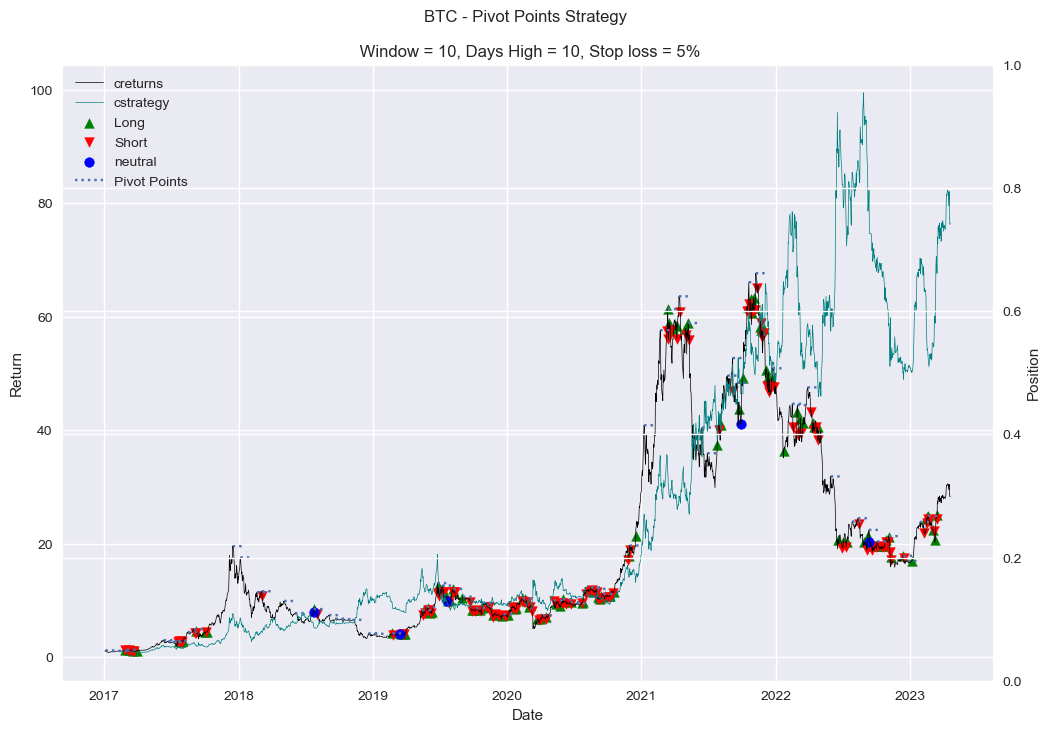

In [7]:
from datetime import datetime, timedelta

def plot_strat(dataframe, window, days_high, stoploss):
    dates = []
    pivots = []

    # Iterate over the rows of the 'pivots_points' column in the DataFrame
    for datetime, row in dataframe.iterrows():
        value = row['pivot_first_hit']
        dates.append(datetime)
        dates.append(datetime + timedelta(days=30))
        pivots.append(value)
        pivots.append(value)

    fig, ax1 = plt.subplots()

    fig.set_figwidth(12)
    fig.set_figheight(8)

    ax2 = ax1.twinx()
    x = dataframe.index
    ax1.plot(x, dataframe.creturns, label="creturns", color = 'black', linewidth=0.5)
    ax1.plot(x, dataframe.cstrategy, label="cstrategy", color = 'teal', linewidth=0.5)

    ax1.scatter(dataframe.index , dataframe.long_price , label = 'Long' , marker = '^', color = 'green',alpha =1)
    ax1.scatter(dataframe.index , dataframe.short_price , label = 'Short' , marker = 'v', color = 'red',alpha =1)
    ax1.scatter(dataframe.index , dataframe.neutral_price , label = 'neutral' , marker = 'o', color = 'blue',alpha =1)
    ax1.plot(dates, pivots, linestyle='dotted', label='Pivot Points')

    ax1.legend()
    ax1.set_xlabel('Date')
    ax2.set_ylabel('Position')
    ax1.set_ylabel('Return')
    ax1.set_title('BTC - Pivot Points Strategy \n\n Window = {}, Days High = {}, Stop loss = {}%'.format(window, days_high, stoploss))

    plt.show()    
    
plot_strat(df, window=window, days_high=days_high, stoploss=stoploss)

In [15]:
def optimize(window, days_high, stoploss):
#     print(window, days_high, stoploss)
    dataframe = df
    dataframe = find_pivs(dataframe, window, days_high)
    dataframe = strat(dataframe, stoploss)
    try: 
        strat_ret = dataframe.cstrategy[-1]
        return pd.DataFrame(
            {'window': window, 
             'days_high':days_high, 
             'stoploss':stoploss, 
             'strat_ret': strat_ret}, 
            index=[0]
        )
    except:
        pass

import multiprocess as mp
from itertools import product

window_range = (1,21)
days_high_range = (1,21)
stoploss = (0, 11)

try:
    cpus = mp.cpu_count()
except NotImplementedError:
     cpus = 2

#run all tests
if __name__ == '__main__':
    with mp.Pool(cpus) as p:
        combinations = list(product(range(*window_range), range(*days_high_range), range(*stoploss)))
        optimizer = p.starmap(optimize, combinations)
        df_optimized = pd.concat(optimizer)
        
df_optimized.sort_values(by='strat_ret', ascending=False, inplace=True)

In [18]:
window = df_optimized.window.iloc[0]
days_high = df_optimized.days_high.iloc[0]
stoploss = df_optimized.stoploss.iloc[0]

best_df = find_pivs(df, window=window, days_high=days_high)
best_df = strat(best_df, stoploss=stoploss)
best_df

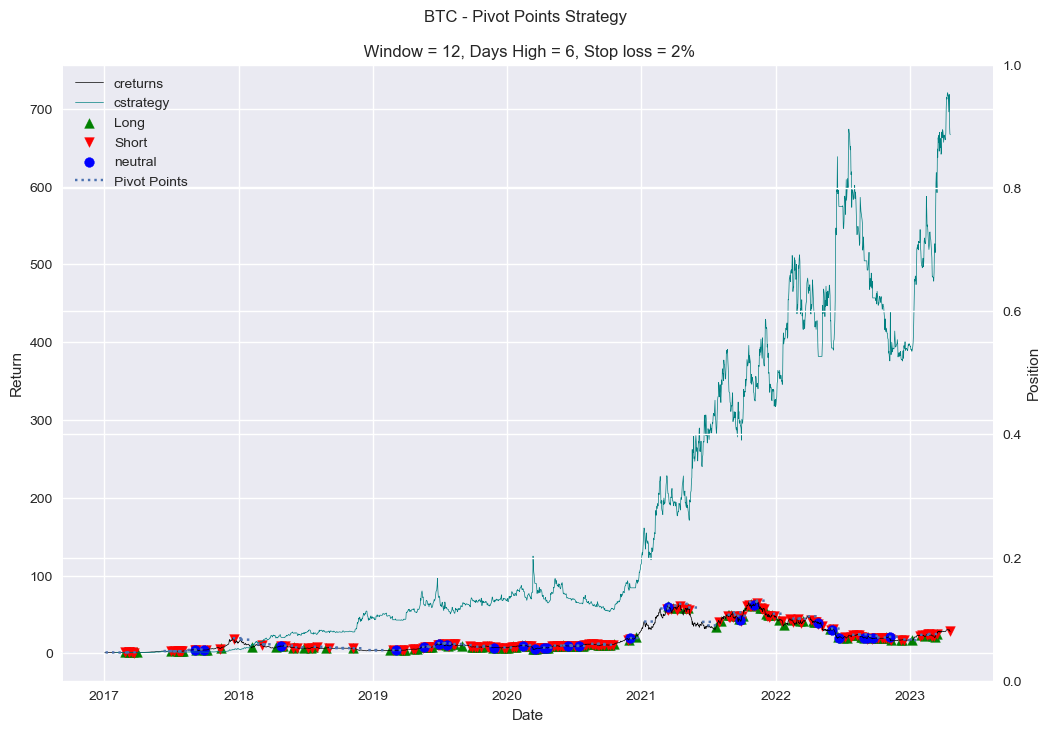

In [21]:
plot_strat(best_df, window, days_high, stoploss)